# Unsupervised VAE analysis & further retraining the last layer

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

#importing fundtion to get encoder info and perfrom tasks 
from finetune.get_finetune_encoder import  get_finetune_input_data

from models.models_VAE import VAE
from pretrain.train_pretrain_VAE import PretrainVAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-10-03 15:59:57.495207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 15:59:57.518164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 15:59:57.524831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 15:59:57.540879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions

CoxPHFitter	 DataLoader	 KaplanMeierFitter	 LabelEncoder	 PretrainVAE	 TensorDataset	 VAE	 accuracy_score	 f1_score	 
get_finetune_input_data	 imaplib	 importlib	 label_encoder	 logrank_test	 ml_code_path	 nn	 np	 optim	 
optuna	 os	 pd	 precision_score	 random	 recall_score	 roc_auc_score	 torch	 


In [2]:
# Define a function to plot the Kaplan-Meier curves for two risk groups
def km_plot_cox_2_risk_groups(all_risks, all_durations, all_events, risk_threshold=0):
    
    # Convert lists to numpy arrays
    all_risks = np.array(all_risks)
    all_durations = np.array(all_durations)
    all_events = np.array(all_events)

    # Separate patients into responders and non-responders
    responders_mask = all_risks < risk_threshold
    non_responders_mask = all_risks >= risk_threshold

    # Count the number of responders and non-responders
    num_responders = np.sum(responders_mask)
    num_non_responders = np.sum(non_responders_mask)

    # Create KaplanMeierFitter objects
    kmf_responders = KaplanMeierFitter()
    kmf_non_responders = KaplanMeierFitter()

    # Fit the KM model for responders
    kmf_responders.fit(all_durations[responders_mask], event_observed=all_events[responders_mask], label=f"Responders (n={num_responders})")
    median_os_responders = kmf_responders.median_survival_time_

    # Fit the KM model for non-responders
    kmf_non_responders.fit(all_durations[non_responders_mask], event_observed=all_events[non_responders_mask], label=f"Non-Responders (n={num_non_responders})")
    median_os_non_responders = kmf_non_responders.median_survival_time_

    # Perform log-rank test to get the p-value
    log_rank_result = logrank_test(all_durations[responders_mask], all_durations[non_responders_mask], 
                                event_observed_A=all_events[responders_mask], event_observed_B=all_events[non_responders_mask])
    p_value = log_rank_result.p_value

    # Plot the KM curves
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get the current axis

    kmf_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})
    kmf_non_responders.plot_survival_function(ax=ax, ci_show=True, show_censors=True, censor_styles={'ms': 5, 'marker': '|'})

    # Add a horizontal line for survival probability of 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')

    # Get the minimum y-axis value to draw vertical lines from 0.5 to the x-axis
    y_min, y_max = ax.get_ylim()

    # Find where the survival curves intersect with the 0.5 survival probability and add vertical lines
    if not np.isnan(median_os_responders):
        plt.plot([median_os_responders, median_os_responders], [0.5, y_min], color='blue', linestyle='--')
        plt.text(median_os_responders, 0.25, f"{median_os_responders:.1f} days", color='blue', fontsize=10, verticalalignment='bottom')

    if not np.isnan(median_os_non_responders):
        plt.plot([median_os_non_responders, median_os_non_responders], [0.5, y_min], color='orange', linestyle='--')
        plt.text(median_os_non_responders, 0.25, f"{median_os_non_responders:.1f} days", color='orange', fontsize=10, verticalalignment='bottom')

    # Customize the plot title with median OS and p-value in scientific notation
    plt.title(f"Kaplan-Meier Curve: Responders vs Non-Responders\n"
              f"Median OS: {median_os_responders:.2f} days (Responders), {median_os_non_responders:.2f} days (Non-Responders)\n"
              f"Log-rank p-value: {p_value:.2e}", fontsize=12)

    # Customize labels and remove grid
    plt.xlabel('Time (in months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)  # Disable the grid

    plt.show()



## Evaluating unsupervised models

#### getting the input data

In [3]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_finetune_OG_split'

finetune_save_dir='/home/leilapirhaji/finetune_unsupervised_VAE'
pretrain_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_list=[143]
pretrain_trial_id=pretrain_trial_list[0]

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'NIVO OS', 'EVER OS', 'PFS']


#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, 

((443, 2736), (443, 58), (149, 2736), (149, 58))

# Adverserial Re-training the last layer of unsupervised VAE models

## grid search par opt

In [22]:
#!/bin/bash
!cd /home/leilapirhaji/mz_embed_engine/ml/

# Define common variables
INPUT_DATA_LOCATION="/home/leilapirhaji/PROCESSED_DATA_finetune_OG_split"
FINETUNE_SAVE_DIR="/home/leilapirhaji/finetune_unsupervised_VAE"
pretrain_model_name="pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1"
pretrain_trial_ID="143"

TASK='NIVO OS'
ADV_TASK='EVER OS'
TASK_EVENT="OS_Event"

# !python ./finetune/retrain_adverserial_cox_finetune_VAE_main.py \
#     --input_data_location "$INPUT_DATA_LOCATION" \
#     --finetune_save_dir "$FINETUNE_SAVE_DIR" \
#     --pretrain_model_name "$pretrain_model_name" \
#     --pretrain_trial_ID "$pretrain_trial_ID" \
#     --task "$TASK" \
#     --adv_task "$ADV_TASk" \
#     --task_event "$TASK_EVENT" \
#     --lambda_adv 0.01 \
#     --add_post_latent_layers 'True' \
#     --post_latent_layer_size "64" \
#     --num_layers_to_retrain "1" \
#     --dropout_rate 1 \
#     --learning_rate 9e-4 \
#     --l1_reg 1e-6 \
#     --weight_decay 1e-3 \
#     --batch_size 32 \
#     --patience 0 \
#     --num_epochs 20

In [108]:
#open the results of grid search
#reading the output
task=TASK.replace(' ','_')
adv_task=ADV_TASK.replace(' ','_')

result_path=f'{FINETUNE_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}_adverserial_{adv_task}'

#best paramteres
with open(f'{result_path}/{task}_best_params_grid_search.txt', 'r') as f:
    best_params = f.read()        

#best model results
best_model_results=pd.read_csv(f'{result_path}/{task}_best_model_results_adverserial.csv')
    
#All grid search results
all_grid_search_results= pd.read_csv(f'{result_path}/{task}_all_grid_search_results.csv')
all_grid_search_results.sort_values('val_c_index_TL', ascending=False, inplace=True)
# Convert a column (e.g., column 'B') to scientific notation
all_grid_search_results['learning_rate'] = all_grid_search_results['learning_rate'].apply(lambda x: '{:.2e}'.format(x))
all_grid_search_results = all_grid_search_results.drop_duplicates()
all_grid_search_results

,add_post_latent_layers,post_latent_layer_size,num_layers_to_retrain,dropout,learning_rate,l1_reg_weight,l2_reg_weight,batch_size,patience,num_epochs,lambda_adv,val_c_index_TL,Adv. C-index,val_loss,delta_c_index
12,True,64,1,0.4,3.00e-05,0.000001,0.001,32,0,20,0.01,0.684831,0.648301,1.570171,0.036529
22,True,64,1,0.4,4.00e-05,0.000001,0.001,32,0,20,0.01,0.684462,0.617539,1.579262,0.066923
2,True,64,1,0.4,1.00e-05,0.000001,0.001,32,0,20,0.01,0.680412,0.632691,1.575379,0.047722
3,True,64,1,0.4,5.00e-05,0.000001,0.001,32,0,20,0.01,0.680412,0.655647,1.562022,0.024765
1,True,64,1,0.4,5.00e-06,0.000001,0.001,32,0,20,0.01,0.677099,0.619835,1.578996,0.057264
5,True,64,1,0.4,5.00e-04,0.000001,0.001,32,0,20,0.01,0.666789,0.635445,1.535507,0.031344
4,True,64,1,0.4,1.00e-04,0.000001,0.001,32,0,20,0.01,0.664948,0.637282,1.574467,0.027667
0,True,64,1,0.4,1.00e-06,0.000001,0.001,32,0,20,0.01,0.647275,0.582645,1.582685,0.064631
20,True,128,1,0.4,9.00e-05,0.000001,0.001,32,0,20,0.01,0.642489,0.639578,1.547924,0.002911
18,True,128,1,0.4,5.00e-05,0.000001,0.001,32,0,20,0.01,0.641016,0.639578,1.554142,0.001439


In [109]:
best_model_results

,Unnamed: 0,Model,Dataset,C-index
0,0,Transfer Learning,Train,0.610711
1,1,Transfer Learning,Validation,0.684462
2,2,Transfer Learning,Test,0.627293


In [110]:
best_params

"{'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'dropout': 0.4, 'learning_rate': 4e-05, 'l1_reg_weight': 1e-06, 'l2_reg_weight': 0.001, 'batch_size': 32, 'patience': 0, 'num_epochs': 20}"

## Evaluating model performances 

In [111]:
model_path=f'{FINETUNE_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}_adverserial_{adv_task}/TL_{task}_best_model_grid_search'

finetune_VAE_file=f'{model_path}/best_model.pth'

finetune_VAE_nivo=torch.load(finetune_VAE_file)
finetune_VAE_nivo.eval()

# first getting the latent rep for the new database using finetune VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert pandas DataFrames to PyTorch tensors
X_test_tensor = torch.tensor(X_data_test.values, dtype=torch.float32).to(device)

latent_reps_test = []
for _ in range(10):  # Run multiple passes
    latent_rep = finetune_VAE_nivo.encoder(X_test_tensor) 
    mu=latent_rep[:, :finetune_VAE_nivo.latent_size]
    latent_reps_test.append(mu)

latent_rep_test_nivo = torch.mean(torch.stack(latent_reps_test), dim=0)

Test C-index: 0.6272927366104182
Fine-tuning completed.


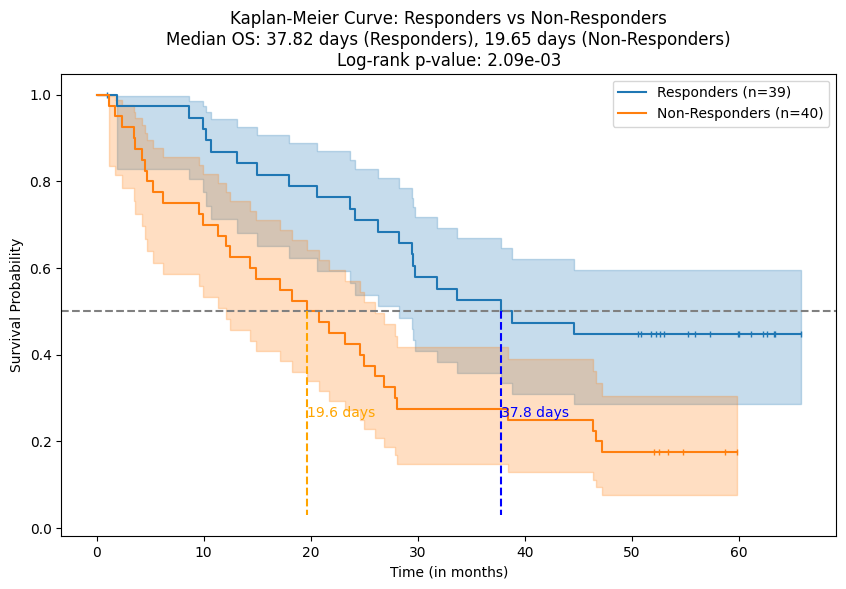

In [112]:
import matplotlib.pyplot as plt
from finetune.best_finetune_model_test_eval_cox import evaluate_model
task='NIVO OS'
task_event='OS_Event'
y_duration_test=y_data_test[task]
y_event_test=y_data_test[task_event]

metrics_test_nivo, all_durations_nivo, all_risks_nivo, all_events_nivo = evaluate_model(finetune_VAE_nivo, latent_rep_test_nivo, y_duration_test, y_event_test, seed=42, batch_size=32)


km_plot_cox_2_risk_groups(all_risks_nivo, all_durations_nivo, all_events_nivo, risk_threshold=np.median(all_risks_nivo))

## Evero OS on NIVO finetune VAE

In [113]:
task_3='EVER OS'
task_event='OS_Event'
y_duration_test=y_data_test[task_3]
y_event_test=y_data_test[task_event]

metrics_test_evero_f_nivo, all_durations_evero_f_nivo, all_risks_evero_f_nivo, all_events_evero_f_nivo = evaluate_model(finetune_VAE_nivo, latent_rep_test_nivo, y_duration_test, y_event_test, seed=42, batch_size=32)

metrics_test_evero_f_nivo

Test C-index: 0.5655629139072847
Fine-tuning completed.


,C-index
0,0.565563


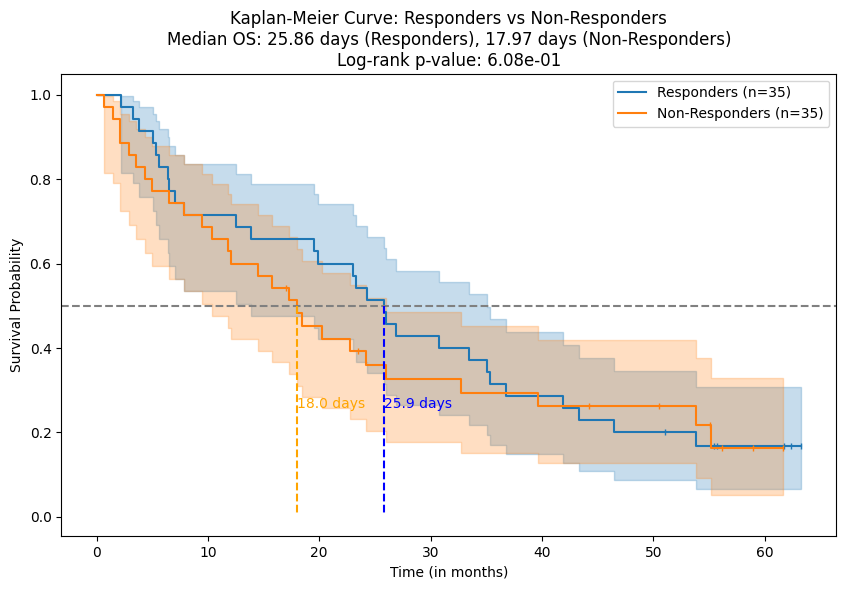

In [114]:
km_plot_cox_2_risk_groups(all_risks_evero_f_nivo, all_durations_evero_f_nivo, all_events_evero_f_nivo, risk_threshold=np.median(all_risks_evero_f_nivo))

### Plotting the latnet space - survival 

Test C-index: 0.6107106939322829
Fine-tuning completed.
Test C-index: 0.6844624447717231
Fine-tuning completed.
Test C-index: 0.6272927366104182
Fine-tuning completed.


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


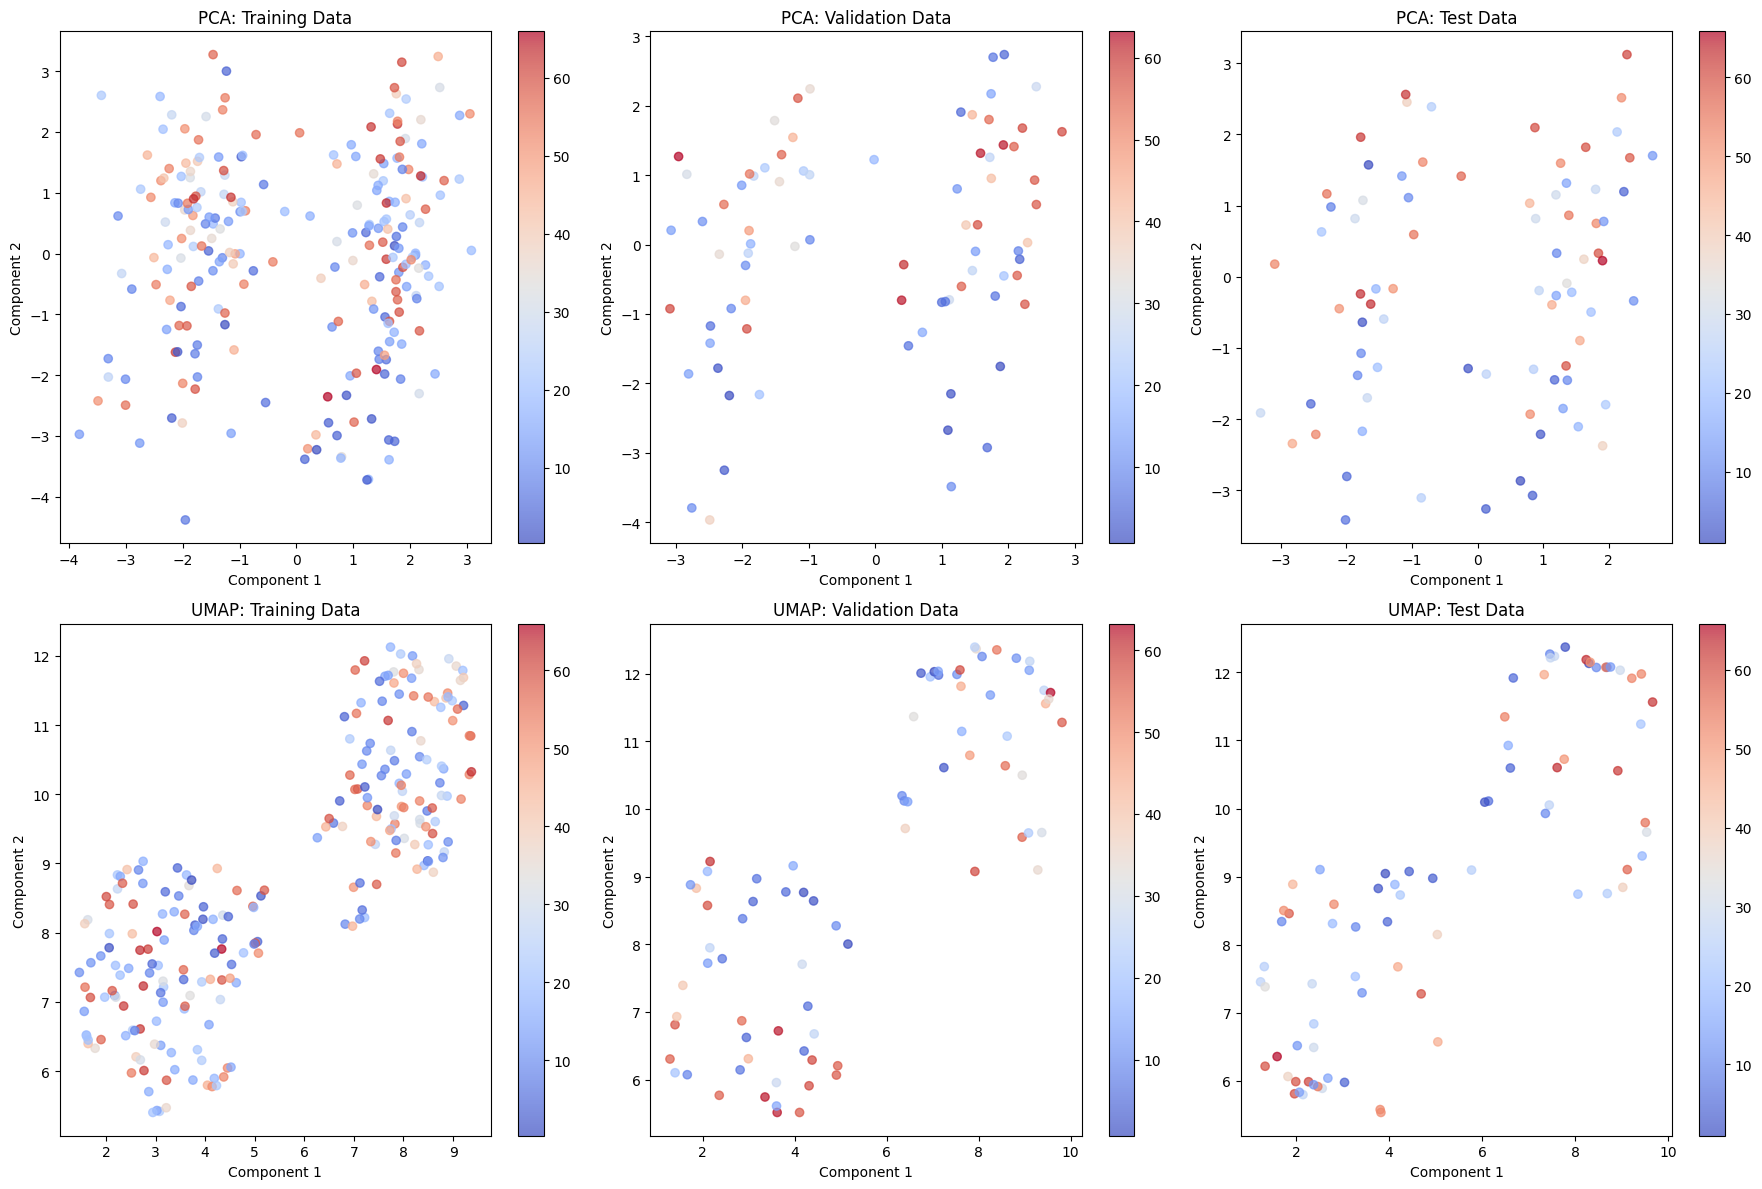

In [99]:
import matplotlib.pyplot as plt
from finetune.best_finetune_model_test_eval_cox import best_model_latent_plot, best_finetune_model_test_eval_cox, best_model_latent_plot_combined
TASK='NIVO OS'
task='NIVO_OS'
adv_task='EVER_OS'
TASK_EVENT='OS_Event'

model_path=f'{finetune_save_dir}/{pretrain_name}/trial_{pretrain_trial_id}/{task}_adverserial_{adv_task}/TL_{task}_best_model_grid_search'
best_model_file=f'{model_path}/best_model.pth'
best_model=torch.load(best_model_file)

result_png_file_TL= f'{model_path}/{task}_best_model_TL_latent_space.png'


combined_result_metrics, latent_rep_train, latent_rep_val, latent_rep_test= best_finetune_model_test_eval_cox(best_model, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, TASK, TASK_EVENT, seed=42)

fig, axes= best_model_latent_plot(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, TASK, TASK_EVENT)

fig.savefig(result_png_file_TL)
plt.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


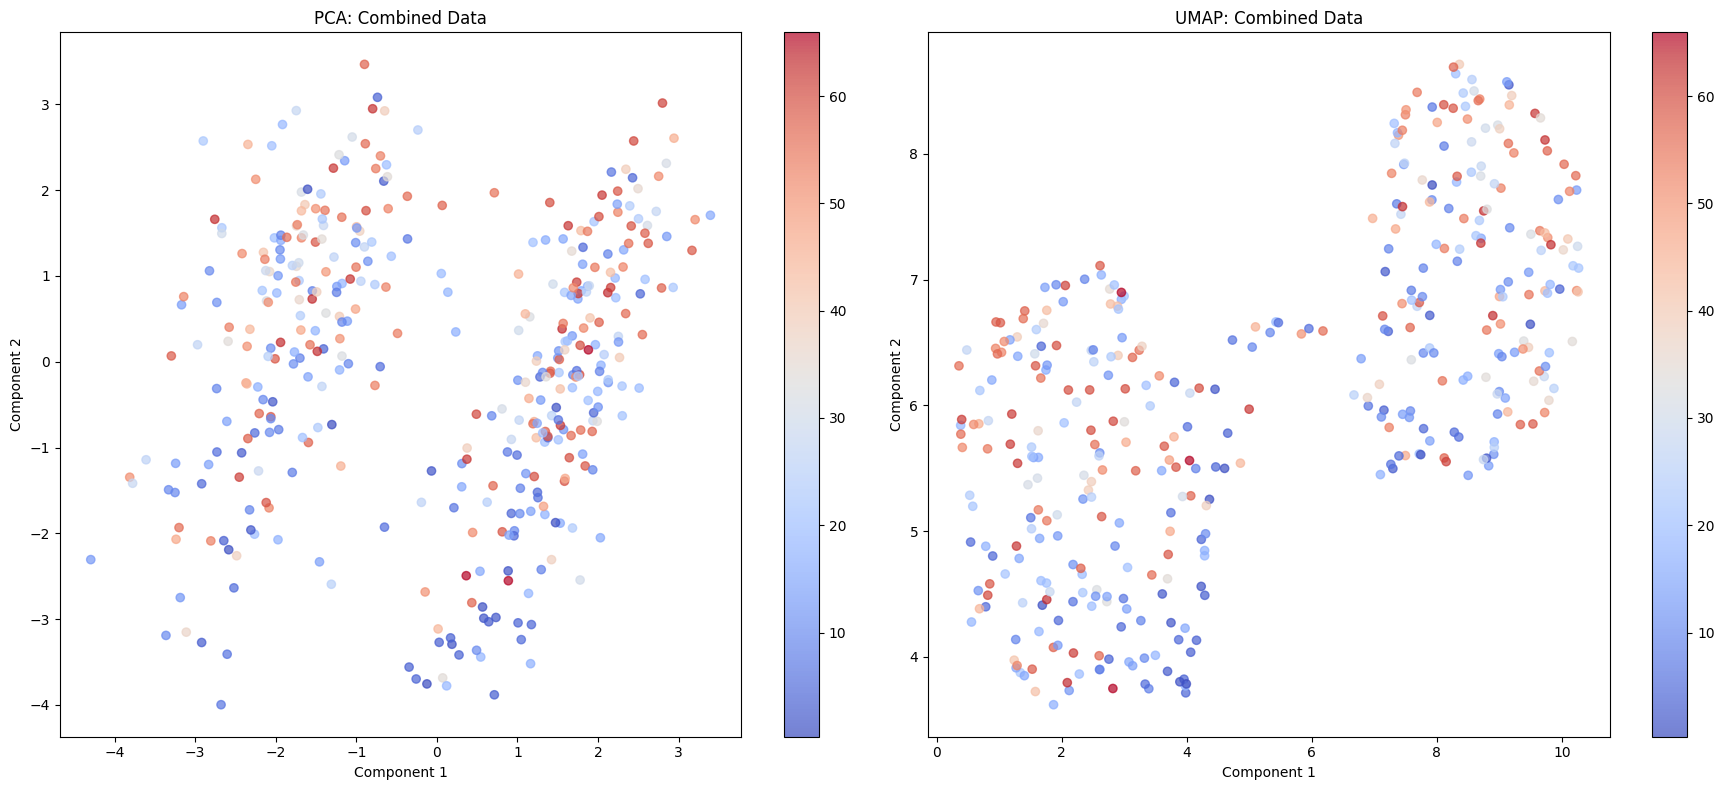

In [100]:
result_png_file_TL= f'{model_path}/{task}_best_model_TL_latent_space_combined.png'
fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, TASK, TASK_EVENT)

fig.savefig(result_png_file_TL)